In [1]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [2]:
! pip install transformers simpletransformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.2 MB 6.6 MB/s 
     |████████████████████████████████| 249 kB 34.0 MB/s 
     |████████████████████████████████| 6.6 MB 48.9 MB/s 
     |████████████████████████████████| 596 kB 40.2 MB/s 
     |████████████████████████████████| 84 kB 3.1 MB/s 
     |████████████████████████████████| 1.8 MB 48.8 MB/s 
     |████████████████████████████████| 1.2 MB 46.0 MB/s 
     |████████████████████████████████| 10.1 MB 47.7 MB/s 
     |████████████████████████████████| 43 kB 1.7 MB/s 
     |████████████████████████████████| 346 kB 43.1 MB/s 
     |████████████████████████████████| 181 kB 27.9 MB/s 
     |████████████████████████████████| 145 kB 55.5 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
     |████████████████████████████████| 212 kB 51.7 MB/s 
     |████████████████████████████████| 86 kB 6.4 MB/s 
     |████████████████████████████████|

In [ ]:
import os
os._exit(00)

In [1]:
%cd drive/MyDrive/CSE4095\ -\ NLP/Delivery-4/

/content/drive/.shortcut-targets-by-id/1FnAGrw_CQ55UcB7YzHg5lCvr8NxMclO5/CSE4095 - NLP/Delivery-4


In [2]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import json
from sklearn.preprocessing import LabelEncoder
import simpletransformers
import os
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
from simpletransformers.classification import ClassificationModel
from tqdm import tqdm
import pickle

# Loading Data

In [3]:
def encode_labels(labels):
    le = LabelEncoder()
    y = le.fit_transform(labels)
    return y

In [4]:
dataset = {}
with open('data/dataset.json', encoding='utf-8') as fr:
    dataset = json.load(fr)

labels = {}
with open('data/labels.json', encoding='utf-8') as fr:
    labels = json.load(fr)

splitted_data = {}
with open('data/splitted_data.json', encoding='utf-8') as fr:
    splitted_data = json.load(fr)
X_train, X_test, y_train, y_test = [], [], [], []

for key in ['train', 'test']:
    for i in range(len(splitted_data[f'X_{key}'])):
        exec(f"X_{key}.append(dataset[splitted_data['X_{key}'][i]])")
        exec(f"y_{key}.append(splitted_data['y_{key}'][i])")

y_train = encode_labels(y_train)
y_test = encode_labels(y_test)

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

2022-05-24 20:56:08.465024: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:39] Overriding allow_growth setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


In [6]:
for example, label in train_dataset.take(1):
    print('texts: ', example.numpy().decode('utf-8'))
    print()
    print('labels: ', label.numpy())

texts:  taraflar arasındaki tazminat davasının yapılan yargılaması sonunda kararda yazılı nedenlerden dolayı davanın kısmen kabulüne dair verilen hükmün süresi içinde davalı vekili tarafından temyiz edilmesi üzerine dosya incelendi gereği düşünüldü davacı vekili davacıya iş yeri sigortası ile sigortalı iş yerinde meydana gelen hırsızlık sonucu çalınan emtia bedelinin sigortalısına ödendiğini ödenen bedelin rücu amacıyla başlatılan icra takibine davalı tarafça itiraz edildiğini yapılan incelemede davalı tarafça kurulan alarm sisteminin arızalı olduğunun ve olay saatinde de çalışmadığı anlaşıldığından davalının hırsızlık olayının meydana gelmesinde kusurunun bulunduğunu belirterek takibe yapılan itirazın iptali ile davalının icra inkar tazminatına mahkum edilmesini talep etmiştir davalı vekili sözleşme maddesi gereğince kendilerine rücu edilemeyeceğini belirterek davanın reddini savunmuştur mahkemece toplanan deliller ve benimsenen bilirkişi raporuna göre davanın reddine karar verilmiş d

2022-05-24 20:56:09.031857: W tensorflow/core/data/root_dataset.cc:200] Optimization loop failed: CANCELLED: Operation was cancelled


# Model Fine-Tuning

In [7]:
# model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
# model_name = "sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2"
# model_name = "serdarakyol/interpress-turkish-news-classification"
model_name = "savasy/bert-base-turkish-sentiment-cased"
# model_name = "savasy/bert-turkish-text-classification"

In [8]:
model_args = {
    "use_early_stopping": True,
    "early_stopping_patience": 5,
    "fp16": True,
    "num_train_epochs": 1,
    'overwrite_output_dir': True,
    'learning_rate': 1e-5,
    "save_steps": -1,
    "evaluate_during_training": False,
    "save_model_every_epoch": False,
    "early_stopping_consider_epochs": True,
    "train_batch_size": 64,
    "eval_batch_size": 64
}

In [9]:
model = ClassificationModel(
    "bert",
    model_name,
    use_cuda=True,
    num_labels=10,
    args=model_args,
    ignore_mismatched_sizes=True,
)

Downloading:   0%|          | 0.00/596 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at savasy/bert-base-turkish-sentiment-cased and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/39.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/256k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [10]:
train_df = pd.DataFrame({"text": X_train, "labels": y_train})
eval_df = pd.DataFrame({"text": X_test, "labels": y_test})

In [11]:
os.makedirs('./models', exist_ok=True)
os.makedirs('./results', exist_ok=True)

In [12]:
best_score = 0
for epoch in tqdm(range(10)):
    history = model.train_model(train_df)
    result, model_outputs, wrong_predictions = model.eval_model(eval_df)
    if result['mcc'] > best_score:
        with open("./models/transformer_best_checkpoint_turkish_sentiment.h5", 'wb') as f: # text_classification
            pickle.dump(model, f)
        
        with open('./results/transformer_best_predictions_turkish_sentiment.npy', 'wb') as f:
            np.save(f, np.array(tf.nn.softmax(model_outputs)))

        best_score = result['mcc']

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 10%|█         | 1/10 [05:25<48:46, 325.19s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 20%|██        | 2/10 [10:34<42:08, 316.10s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 30%|███       | 3/10 [15:44<36:31, 313.10s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 40%|████      | 4/10 [20:53<31:09, 311.58s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 50%|█████     | 5/10 [26:03<25:54, 310.89s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 60%|██████    | 6/10 [31:13<20:42, 310.68s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 70%|███████   | 7/10 [36:23<15:31, 310.45s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 80%|████████  | 8/10 [41:34<10:21, 310.52s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [46:44<05:10, 310.52s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

100%|██████████| 10/10 [51:53<00:00, 311.37s/it]


In [476]:
print('Ayaz')

Ayaz


In [13]:
best_score, result

(0.865021314021252,
 {'mcc': 0.8631863209439269, 'eval_loss': 0.3091517553072084})

In [14]:
with open("./models/transformer_best_checkpoint_turkish_sentiment.h5", 'rb') as f:
    model = pickle.load(f)
        
with open('./results/transformer_best_predictions_turkish_sentiment.npy', 'rb') as f:
    model_outputs = np.load(f)

In [15]:
y_pred = np.argmax(model_outputs, axis=1)

In [16]:
classes = ["Asliye Ceza Mahkemesi", "Asliye Hukuk Mahkemesi", "Ağır Ceza Mahkemesi", "Bölge Adliye Mahkemesi",
           "Ceza Dairesi", "EMPTY", "OTHER", "Ticaret Mahkemesi", "Çocuk Mahkemesi", "İş Mahkemesi"]

In [17]:
cr = classification_report(y_test, y_pred, target_names=classes)
print(cr)

                        precision    recall  f1-score   support

 Asliye Ceza Mahkemesi       0.90      0.96      0.93      1998
Asliye Hukuk Mahkemesi       0.76      0.82      0.79       393
   Ağır Ceza Mahkemesi       0.88      0.66      0.76       380
Bölge Adliye Mahkemesi       0.92      0.94      0.93       487
          Ceza Dairesi       0.98      0.98      0.98       219
                 EMPTY       0.95      0.94      0.94      1325
                 OTHER       0.75      0.66      0.70       241
     Ticaret Mahkemesi       0.73      0.70      0.72        84
       Çocuk Mahkemesi       0.64      0.62      0.63       179
          İş Mahkemesi       0.95      0.94      0.94       263

              accuracy                           0.89      5569
             macro avg       0.85      0.82      0.83      5569
          weighted avg       0.89      0.89      0.89      5569



In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

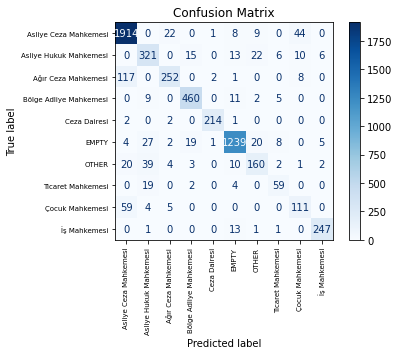

In [19]:
disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=classes,
        cmap=plt.cm.Blues,
        normalize=None,
    )
disp.ax_.set_title('Confusion Matrix')

plt.xticks(rotation = 90, fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('results/transformer_sentiment_cm.png', dpi=300, bbox_inches='tight')

In [20]:
model_name = "savasy/bert-turkish-text-classification"

In [21]:
model_args = {
    "use_early_stopping": True,
    "early_stopping_patience": 5,
    "fp16": True,
    "num_train_epochs": 1,
    'overwrite_output_dir': True,
    'learning_rate': 1e-5,
    "save_steps": -1,
    "evaluate_during_training": False,
    "save_model_every_epoch": False,
    "early_stopping_consider_epochs": True,
    "train_batch_size": 64,
    "eval_batch_size": 64
}

In [22]:
model = ClassificationModel(
    "bert",
    model_name,
    use_cuda=True,
    num_labels=10,
    args=model_args,
    ignore_mismatched_sizes=True,
)

Downloading:   0%|          | 0.00/751 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at savasy/bert-turkish-text-classification and are newly initialized because the shapes did not match:
- classifier.weight: found shape torch.Size([7, 768]) in the checkpoint and torch.Size([10, 768]) in the model instantiated
- classifier.bias: found shape torch.Size([7]) in the checkpoint and torch.Size([10]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Downloading:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/245k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [23]:
train_df = pd.DataFrame({"text": X_train, "labels": y_train})
eval_df = pd.DataFrame({"text": X_test, "labels": y_test})

In [24]:
os.makedirs('./models', exist_ok=True)
os.makedirs('./results', exist_ok=True)

In [25]:
best_score = 0
for epoch in tqdm(range(10)):
    history = model.train_model(train_df)
    result, model_outputs, wrong_predictions = model.eval_model(eval_df)
    if result['mcc'] > best_score:
        with open("./models/transformer_best_checkpoint_text_classification.h5", 'wb') as f: # text_classification
            pickle.dump(model, f)
        
        with open('./results/transformer_best_predictions_text_classification.npy', 'wb') as f:
            np.save(f, np.array(tf.nn.softmax(model_outputs)))

        best_score = result['mcc']

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 10%|█         | 1/10 [05:09<46:25, 309.51s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 20%|██        | 2/10 [10:20<41:22, 310.33s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 30%|███       | 3/10 [15:33<36:20, 311.50s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 40%|████      | 4/10 [20:45<31:11, 311.93s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 50%|█████     | 5/10 [25:58<26:00, 312.06s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 60%|██████    | 6/10 [31:10<20:48, 312.05s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 70%|███████   | 7/10 [36:21<15:35, 311.94s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 80%|████████  | 8/10 [41:33<10:23, 311.76s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [46:44<05:11, 311.58s/it]

  0%|          | 0/22273 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 0 of 1:   0%|          | 0/349 [00:00<?, ?it/s]

  0%|          | 0/5569 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/88 [00:00<?, ?it/s]

100%|██████████| 10/10 [51:54<00:00, 311.40s/it]


In [26]:
with open("./models/transformer_best_checkpoint_text_classification.h5", 'rb') as f:
    model = pickle.load(f)
        
with open('./results/transformer_best_predictions_text_classification.npy', 'rb') as f:
    model_outputs = np.load(f)

In [27]:
y_pred = np.argmax(model_outputs, axis=1)

In [28]:
classes = ["Asliye Ceza Mahkemesi", "Asliye Hukuk Mahkemesi", "Ağır Ceza Mahkemesi", "Bölge Adliye Mahkemesi",
           "Ceza Dairesi", "EMPTY", "OTHER", "Ticaret Mahkemesi", "Çocuk Mahkemesi", "İş Mahkemesi"]

In [29]:
cr = classification_report(y_test, y_pred, target_names=classes)
print(cr)

                        precision    recall  f1-score   support

 Asliye Ceza Mahkemesi       0.93      0.94      0.93      1998
Asliye Hukuk Mahkemesi       0.79      0.82      0.81       393
   Ağır Ceza Mahkemesi       0.83      0.69      0.76       380
Bölge Adliye Mahkemesi       0.91      0.96      0.94       487
          Ceza Dairesi       0.98      0.98      0.98       219
                 EMPTY       0.96      0.93      0.94      1325
                 OTHER       0.79      0.70      0.74       241
     Ticaret Mahkemesi       0.75      0.74      0.74        84
       Çocuk Mahkemesi       0.60      0.78      0.68       179
          İş Mahkemesi       0.93      0.94      0.93       263

              accuracy                           0.90      5569
             macro avg       0.85      0.85      0.85      5569
          weighted avg       0.90      0.90      0.90      5569



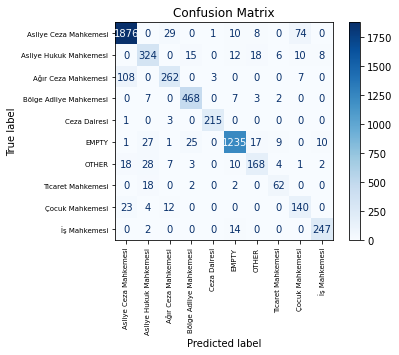

In [30]:
disp = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        display_labels=classes,
        cmap=plt.cm.Blues,
        normalize=None,
    )
disp.ax_.set_title('Confusion Matrix')

plt.xticks(rotation = 90, fontsize=7)
plt.yticks(fontsize=7)
plt.savefig('results/transformer_classification_cm.png', dpi=300, bbox_inches='tight')